In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import matplotlib.image as img
path = '../input/faces/faces/'

# Any results you write to the current directory are saved as output.

In [2]:
all_data = []
for file in os.listdir('../input/faces/faces'):
    i = img.imread(path + file)
    all_data.append(i)

In [3]:
len(all_data)

33431

In [4]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
all_data = np.array(all_data)
all_data = all_data.reshape(all_data.shape[0], 96 * 96 * 3)
all_data = minmax.fit_transform(all_data)
all_data = all_data.reshape(all_data.shape[0], 96, 96, 3)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Reshape,Conv2D,Activation,Input,UpSampling2D,ZeroPadding2D,Flatten,Lambda
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [6]:
noise_dim = 100

In [7]:
def plot_images(samples):
    samples = (samples + 1) / 2 ## 对图像再转到(0,1)
    fig, axes = plt.subplots(nrows=1, ncols=15, sharex=True, sharey=True, figsize=(30,2))
    for img, ax in zip(samples, axes):
        ax.imshow(img.reshape((96, 96, 3)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0)

In [8]:
def loss_func(y_true, y_predict):
    return - K.mean(K.log(K.maximum(K.epsilon(), y_predict)))


class GANModel():

    def __init__(self):
        self.input = [Input(shape = (noise_dim,),name = 'gen'), Input(shape = (96, 96, 3),name = 'dis')]
        ## generator layers
        self.gen =[
            Dense(128 * 24 * 24, activation = 'relu'),
            Reshape((24, 24, 128)),
            UpSampling2D(),
            Conv2D(
                filters = 128,
                kernel_size = 4,
                padding = 'same'
            ),
            Activation('relu'),
            UpSampling2D(),
            Conv2D(
                filters = 64,
                kernel_size = 4,
                padding = 'same'
            ),
            Activation('relu'),

            Conv2D(
                filters = 3,
                kernel_size = 4,
                padding = 'same'
            ),
            Activation('tanh')
        ]
        ## discriminator layer
        self.dis = [
            Reshape((96, 96, 3)),
            Conv2D(
                filters = 32,
                kernel_size = 4,
                padding = 'same'
            ),
            Activation('relu'),
            Conv2D(
                filters = 64,
                kernel_size = 4,
                padding = 'same'
            ),
            ZeroPadding2D(),
            Activation('relu'),
            Conv2D(
                filters = 128,
                kernel_size = 4,
                padding = 'same'
            ),
            Activation('relu'),
            Conv2D(
                filters = 256,
                kernel_size = 4,
                padding = 'same'
            ),
            Activation('relu'),
            Flatten(),
            Dense(1, activation = 'sigmoid')
        ]
        self.gen_out = self.input[0]
        for l in self.gen:
            self.gen_out = l(self.gen_out)
        self.dis_out = self.input[1]

        # print(self.dis_out)

        for l in self.dis:
            self.dis_out = l(self.dis_out)
        self.optimizer1 = Adam(lr = 0.0001,beta_1 = 0.4)
        self.optimizer2 = Adam(lr = 0.0001,beta_1 = 0.4)

    def get_dis_model(self):
        for l in self.gen:
            l.trainable = False
        for l in self.dis:
            l.trainable = True
        discriminateor_out1 = self.dis_out ##这是真实样本的的输出
        output = self.get_dis()
        discriminateor_out2 = Lambda(lambda y: 1. - y)(output) #这是假样本的输出

        self.__discriminateor_model = Model(self.input, [discriminateor_out2,discriminateor_out1])
        self.__discriminateor_model.compile(self.optimizer1,loss = loss_func)

#         self.discriminateor_model = Model(self.input[1], self.dis_out)
#         self.discriminateor_model.compile(self.optimizer1,loss = loss_func)

    def get_gen_model(self):
        for l in self.gen:
            l.trainable = True
        for l in self.dis:
            l.trainable = False

        out = self.get_dis()

        self.__generator_model = Model(self.input[0], out)
        self.__generator_model.compile(self.optimizer2,
                                       loss =loss_func)
#         print(self.__generator_model.summary())
        self.generator_model = Model(self.input[0], self.gen_out)

    def train(self, sample_list, epoch = 3, batch_size = 32, step_per = 10, plot = False):
        '''
        step_per: 每隔几步训练一次generator
        '''
        sample_noise, sample_true = sample_list["unreal"], sample_list["real"]
        sample_count = sample_noise.shape[0]
        batch_count = sample_count // batch_size
        psudo_y = np.ones((batch_size,), dtype = 'float32')

        for ei in range(epoch):
            print('iterator : ' ,ei)
#             for i in range(step_per):
            for i in range(batch_count - 1):
#                 idx = np.random.randint(0, batch_count - 1)
                batch_noise = sample_noise[i * batch_size: (i + 1) * batch_size]
#                 idx = np.random.randint(0, batch_count - 1)
                batch_sample = sample_true[i * batch_size: (i + 1) * batch_size]
                batch_sample = batch_sample * 2 - 1
                loss_dis = self.__discriminateor_model.train_on_batch({
                    "dis": batch_sample,
                    "gen": batch_noise},
                    [psudo_y, psudo_y])
#                 print(self.__discriminateor_model.metrics_names)
#                 print('discriminateor is :  ',loss_dis)

#                 idx =  np.random.randint(0, batch_count - 1)
#                 batch_noise = sample_noise[i * batch_size: (i + 1) * batch_size]
                loss_gen = self.__generator_model.train_on_batch(batch_noise, psudo_y)
#                 print('generator is :  ',loss_gen)

            if ei == 0 or ei == 1:
                test = np.random.random(size = (15,noise_dim))
                img = self.generator_model.predict(test)
                plot_images(img)

    def get_dis(self):
        result = self.gen_out
        for l in self.dis:
            result = l(result)
        return result

Instructions for updating:
Colocations handled automatically by placer.
iterator :  0


/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


iterator :  1


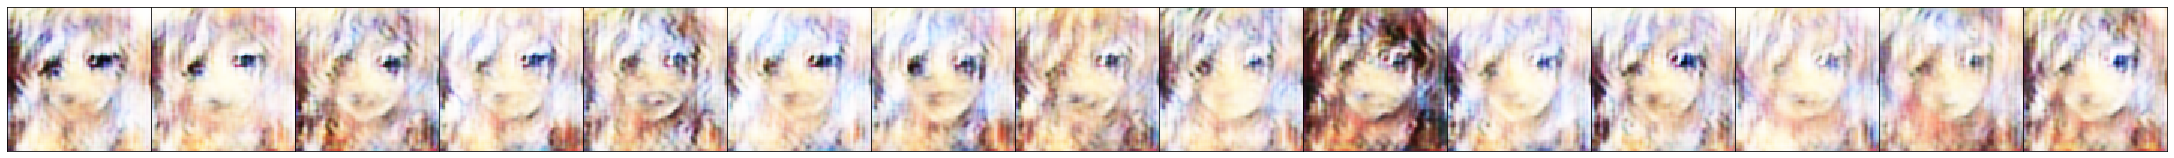

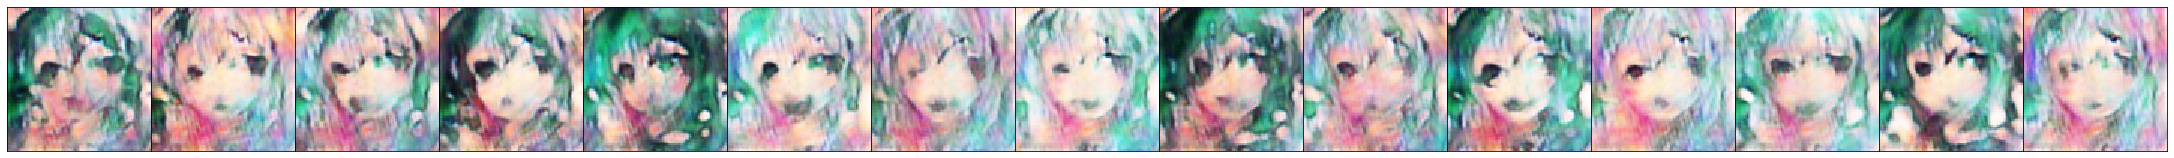

In [9]:
iterator_num =2

batch_size = 128
noise = np.random.uniform(-1,1, size = (len(all_data),noise_dim))
sample = {
    'real':all_data,
    'unreal': noise
}
gan = GANModel()
gan.get_dis_model()
gan.get_gen_model()

gan.train(sample_list = sample,epoch = iterator_num)